This example is taken from https://coderzcolumn.com/tutorials/artificial-intelligence/object-detection-using-pre-trained-pytorch-models

# PyTorch Object Detection using Pre-Trained Models
1. Load Sample Images
- 1.1 Download Sample Images
- 1.2 Load Images as Pillow Images
- 1.3 Convert Pillow Images to Torch Tensors
- 1.4 Add Batch Dimension
- 1.5 Convert Images Represented as Integer (0-255) to Floats (0-1)
2. Load Pre-Trained PyTorch Model (Faster R-CNN with ResNet50 Backbone)
3. Make Predictions
4. Visualize Results
- 4.1 Load Target Classes Mapping
- 4.2 Map Target Category Ids to Labels
- 4.3 Visualize Bounding Boxes On Original Images
5. Try Other Pre-Trained Models

Below, we have imported the necessary Python libraries that we'll use for our tutorial. We have also printed the versions that we have used in our tutorial.

In [1]:
import torch
print("PyTorch Version : {}".format(torch.__version__))

PyTorch Version : 2.2.1+cu121


In [2]:
import torchvision
print("TorchVision Version : {}".format(torchvision.__version__))

TorchVision Version : 0.17.1+cu121


In [3]:
import pycocotools
#This library will be used for computing the evaluation
#metrics following the COCO metric for intersection over union.

## 1. Load Sample Images

In this section, we have simply downloaded a few images from the internet, load them as Pillow images, and then converted them to torch tensors for giving them to model for prediction. We need to convert images to tensors before giving them to the network always as they work on tensors only.

### 1.1 Download Sample Images

Below, we have simply downloaded two images from the Internet using wget shell command. We have selected images randomly. Please feel free to use your images if you have some ready that you want to try.

In [4]:
!wget https://storage.googleapis.com/coderzcolumn/static/tutorials/artificial_intelligence/pytorch-object-detection-using-pre-trained-models-1.jpg
!wget https://gumlet.assettype.com/freepressjournal/import/2016/07/kids-playing.jpg

--2024-04-23 13:24:37--  https://storage.googleapis.com/coderzcolumn/static/tutorials/artificial_intelligence/pytorch-object-detection-using-pre-trained-models-1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33681 (33K) [image/jpeg]
Saving to: ‘pytorch-object-detection-using-pre-trained-models-1.jpg’

pytorch-object-dete 100%[===================>]  32.89K  --.-KB/s    in 0.02s   

2024-04-23 13:24:37 (1.50 MB/s) - ‘pytorch-object-detection-using-pre-trained-models-1.jpg’ saved [33681/33681]

--2024-04-23 13:24:37--  https://gumlet.assettype.com/freepressjournal/import/2016/07/kids-playing.jpg
Resolving gumlet.assettype.com (gumlet.assettype.com)... 104.22.27.212, 172.67.27.232, 104.22.26.212, ...
Connecting to gumlet.assettype.com (gumlet.assettype.com)|104.22.27.212|:

### 1.2 Load Images as Pillow Images

In this section, we have loaded images in memory using Python module pillow. After loading images, we have also displayed them. Both images have people in them. The first image is of the family on vacation and the second image has children playing ball. Next, we'll convert these images to torch tensors.


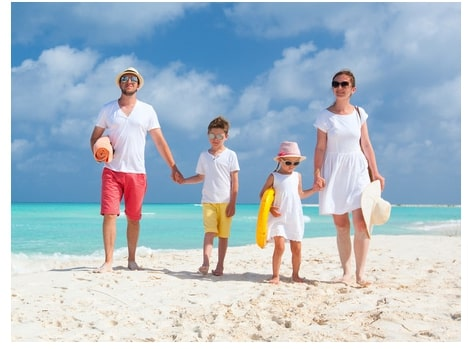

In [5]:
from PIL import Image

holiday = Image.open("pytorch-object-detection-using-pre-trained-models-1.jpg")

holiday

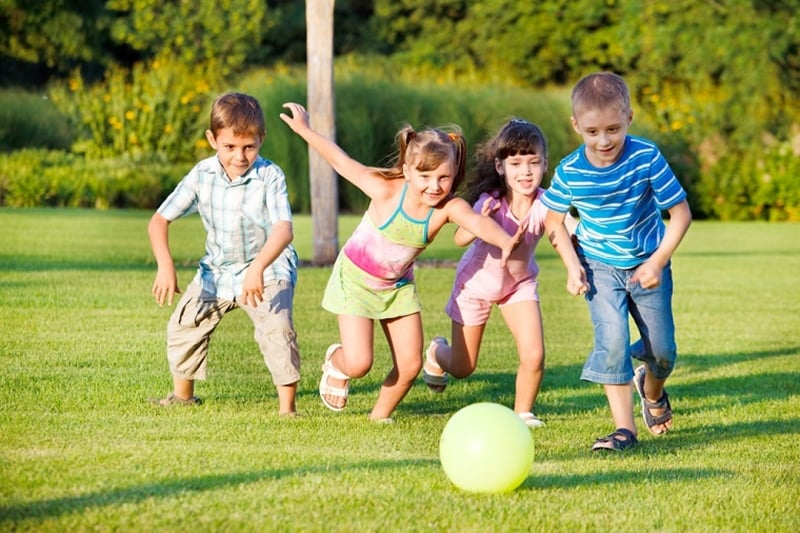

In [6]:
kids_playing = Image.open("kids-playing.jpg")

kids_playing

### 1.3 Convert Pillow Images to Torch Tensors

In this section, we have simply converted Pillow images to torch tensors. We have used the functional API of torchvision module to convert images to tensors. The transforms sub-module of torchvision has a method named pil_to_tensor() that can help us convert images to tensors. The tensors have shape (channels, height, width). As our images are RGB, we have 3 channels.

In [7]:
from torchvision.transforms.functional import pil_to_tensor

holiday_tensor_int = pil_to_tensor(holiday)
kids_playing_tensor_int = pil_to_tensor(kids_playing)

holiday_tensor_int.shape, kids_playing_tensor_int.shape

(torch.Size([3, 349, 468]), torch.Size([3, 533, 800]))

### 1.4 Add Batch Dimension

In this section, we have simply added one dimension at the beginning of our images which is the batch dimension. We added this dimension because models work on batches of images.

In [8]:
holiday_tensor_int = holiday_tensor_int.unsqueeze(dim=0)
kids_playing_tensor_int = kids_playing_tensor_int.unsqueeze(dim=0)

holiday_tensor_int.shape, kids_playing_tensor_int.shape

(torch.Size([1, 3, 349, 468]), torch.Size([1, 3, 533, 800]))

### 1.5 Convert Images Represented as Integer (0-255) to Floats (0-1)

By default, the image tensors are integer tensors that have values in the range 0-255. The PyTorch pre-trained models are generally trained on images represented as float tensors. So, we have created new copies of our images represented as float tensors by dividing integer tensors by 255. We'll require integer tensors in features when plotting it again with bounding boxes.

In [9]:
print(holiday_tensor_int.min(), holiday_tensor_int.max())

holiday_tensor_float = holiday_tensor_int / 255.0
kids_playing_tensor_float = kids_playing_tensor_int / 255.0

print(holiday_tensor_float.min(), holiday_tensor_float.max())

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0.) tensor(1.)


## 2. Load Pre-Trained PyTorch Model (Faster R-CNN with ResNet50 Backbone)

In this section, we have loaded our first pre-trained PyTorch model. The pre-trained models are available from sub-modules of models module of torchvision library. Pytorch has a separate library torchvision for working with vision-related tasks. It provides helper functions to simplify tasks related to computer vision.

The sub-module named detection provides us with various methods that can be called to load pre-trained object detection models. We have loaded the Faster R-CNN model for our purpose. It uses ResNet-50-FPN (Feature Pyramid Network) network for detecting important features in images. We have loaded network by calling method fasterrcnn_resnet50_fpn(). We have provided it with parameters pretrained set to True because we want a network with trained parameters. Currently, by default, they load weights of a model trained on COCO dataset which has around 91 categories of objects.

If you have enough data and you can train the network by yourself then you can load just architecture by setting pretrained to False.

After loading the model, we have set it in evaluation mode by calling eval() method. This will prevent the calculation of gradients which happens during the training phase which is set by default.

In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

object_detection_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)

object_detection_model.eval(); ## Setting Model for Evaluation/Prediction

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [12]:
object_detection_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 3. Make Predictions

Here, we have made predictions on our images using our train model. We have made predictions on both images. The output of the model is a dictionary with three keys.

- boxes - It has shape (no_of_objects, 4). The 4 numbers for each object represents bounding box covering object represented as (top-x, top-y, bottom-x, bottom-y).
- labels - It has a list of labels of detected objects. Currently, it'll be integer values but we'll convert them to target labels by loading mapping from COCO website.
- scores - It has probabilities of detected objects saying how much confident the model was in detecting these objects.

After making predictions, we have removed objects where the model has a prediction probability less than 0.8.

In [13]:
holiday_preds = object_detection_model(holiday_tensor_float)

holiday_preds

[{'boxes': tensor([[ 89.2648,  66.8312, 184.3584, 276.1645],
          [310.8758,  68.5162, 386.7720, 289.1223],
          [255.7148, 140.6521, 326.2658, 285.3147],
          [168.5390, 115.7607, 239.1008, 275.5938],
          [269.9443, 205.6710, 281.2102, 217.3403],
          [ 94.1588, 137.0965, 113.6949, 162.4117],
          [255.4703, 183.9477, 275.2617, 248.9724],
          [360.7684, 179.2540, 391.7480, 228.9238],
          [255.2728, 187.1951, 275.2249, 248.4717],
          [ 93.7025, 137.2011, 113.3836, 162.2162],
          [361.0876, 180.2847, 391.7548, 228.8351],
          [360.3835, 178.8118, 392.3822, 232.0590]], grad_fn=<StackBackward0>),
  'labels': tensor([ 1,  1,  1,  1, 34, 37, 42, 31, 34, 34, 34, 43]),
  'scores': tensor([0.9998, 0.9997, 0.9996, 0.9992, 0.8855, 0.8745, 0.6618, 0.6245, 0.5698,
          0.5012, 0.1575, 0.1089], grad_fn=<IndexBackward0>)}]

In [14]:
holiday_preds[0]["boxes"] = holiday_preds[0]["boxes"][holiday_preds[0]["scores"] > 0.8]
holiday_preds[0]["labels"] = holiday_preds[0]["labels"][holiday_preds[0]["scores"] > 0.8]
holiday_preds[0]["scores"] = holiday_preds[0]["scores"][holiday_preds[0]["scores"] > 0.8]

holiday_preds

[{'boxes': tensor([[ 89.2648,  66.8312, 184.3584, 276.1645],
          [310.8758,  68.5162, 386.7720, 289.1223],
          [255.7148, 140.6521, 326.2658, 285.3147],
          [168.5390, 115.7607, 239.1008, 275.5938],
          [269.9443, 205.6710, 281.2102, 217.3403],
          [ 94.1588, 137.0965, 113.6949, 162.4117]], grad_fn=<IndexBackward0>),
  'labels': tensor([ 1,  1,  1,  1, 34, 37]),
  'scores': tensor([0.9998, 0.9997, 0.9996, 0.9992, 0.8855, 0.8745],
         grad_fn=<IndexBackward0>)}]

In [15]:
kids_preds = object_detection_model(kids_playing_tensor_float)

kids_preds

[{'boxes': tensor([[143.5452,  93.2145, 308.8880, 414.3820],
          [533.2533,  69.8312, 692.0643, 454.5066],
          [287.5751, 105.9812, 480.8332, 420.2033],
          [420.7459, 116.1418, 565.6720, 425.2195],
          [437.5051, 402.8449, 534.8459, 496.0176],
          [402.4595, 133.2956, 506.7115, 410.6631],
          [435.3433, 122.4658, 467.4966, 201.6876],
          [436.2111, 400.6835, 538.5056, 497.5849],
          [422.0364, 338.0685, 449.4901, 386.1272]], grad_fn=<StackBackward0>),
  'labels': tensor([ 1,  1,  1,  1, 37,  1,  1, 34, 37]),
  'scores': tensor([0.9998, 0.9998, 0.9985, 0.9975, 0.9885, 0.1234, 0.0864, 0.0626, 0.0605],
         grad_fn=<IndexBackward0>)}]

In [16]:
kids_preds[0]["boxes"] = kids_preds[0]["boxes"][kids_preds[0]["scores"] > 0.8]
kids_preds[0]["labels"] = kids_preds[0]["labels"][kids_preds[0]["scores"] > 0.8]
kids_preds[0]["scores"] = kids_preds[0]["scores"][kids_preds[0]["scores"] > 0.8]

kids_preds

[{'boxes': tensor([[143.5452,  93.2145, 308.8880, 414.3820],
          [533.2533,  69.8312, 692.0643, 454.5066],
          [287.5751, 105.9812, 480.8332, 420.2033],
          [420.7459, 116.1418, 565.6720, 425.2195],
          [437.5051, 402.8449, 534.8459, 496.0176]], grad_fn=<IndexBackward0>),
  'labels': tensor([ 1,  1,  1,  1, 37]),
  'scores': tensor([0.9998, 0.9998, 0.9985, 0.9975, 0.9885], grad_fn=<IndexBackward0>)}]

## 4. Visualize Results

Now, at last, we'll visualize prediction results. In order to do that, we first need to retrieve the mapping of integer target labels to their actual string target labels (like 1:person, 34:frisbee etc.). We'll download and load mapping from COCO website first.


### 4.1 Load Target Classes Mapping

Below, we have downloaded annotations from COCO website as a zip file and then unzipped it. You'll need unzip command installed on your computer for running the below cell. If you don't have unzip installed and you want to do it using Python then you can use zipfile module as well.

In [17]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

--2024-04-23 13:37:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.108.145, 52.216.49.25, 3.5.1.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.108.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  13.5MB/s    in 20s     

2024-04-23 13:37:50 (12.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


Below, we have created an instance of COCO from pycocotools library. We had provided information for installing this library earlier. It provides an API to access various datasets and annotation files available from COCO. This coco object has various methods that can be very helpful. We'll use one such method next to retrieve the actual labels of our target classes.

In [18]:
from pycocotools.coco import COCO

annFile='annotations/instances_val2017.json'

coco=COCO(annFile)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


### 4.2 Map Target Category Ids to Labels

Below, we have retrieved actual string target labels by calling loadCats() method on COCO object. We have provided original integer labels to the method. Next, we'll use these string labels when displaying predictions.

In [19]:
holiday_labels = coco.loadCats(holiday_preds[0]["labels"].numpy())

holiday_labels

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'},
 {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}]

In [20]:
kids_labels = coco.loadCats(kids_preds[0]["labels"].numpy())

kids_labels

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}]

### 4.3 Visualize Bounding Boxes On Original Images

Here, we are visualizing images with objects detected by the model surrounded by bounding boxes and a title at the top with a score. We have first below merger labels and their score to create new labels.

Then, we have called utility visualization function named draw_bounding_boxes() provided by torchvision module's utils sub-module. We have provided function with our image (as integer tensor), bounding boxes, modified labels, and color guide. We have asked to color "person" object red and all other objects green. The output of the function is a torch tensor which has bounding boxes and labels included in them.

To visualize image, we have converted tensors to Pillow images by calling to_pil_image() function available functional API of torchvision.

We have visualized both images. We can notice that in the case of the first image, it correctly predicts "person" objects. It is even making a few mistakes like predicting mat as sports ball, float tube as Frisbee, and not recognizing hat. For the second image, it correctly detects all objects. It is able to detect a child partly hidden behind other children.

In [21]:
from torchvision.utils import draw_bounding_boxes

holiday_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(holiday_labels, holiday_preds[0]["scores"].detach().numpy())]

holiday_output = draw_bounding_boxes(image=holiday_tensor_int[0],
                             boxes=holiday_preds[0]["boxes"],
                             labels=holiday_annot_labels,
                             colors=["red" if label["name"]=="person" else "green" for label in holiday_labels],
                             width=2
                            )

holiday_output.shape

torch.Size([3, 349, 468])

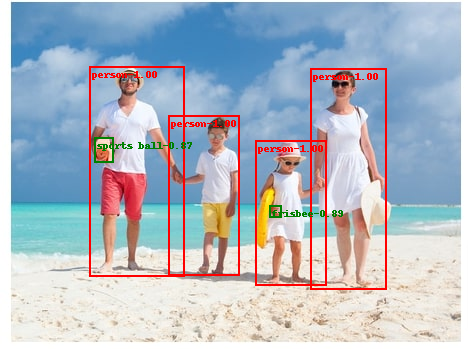

In [22]:
from torchvision.transforms.functional import to_pil_image

to_pil_image(holiday_output)

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


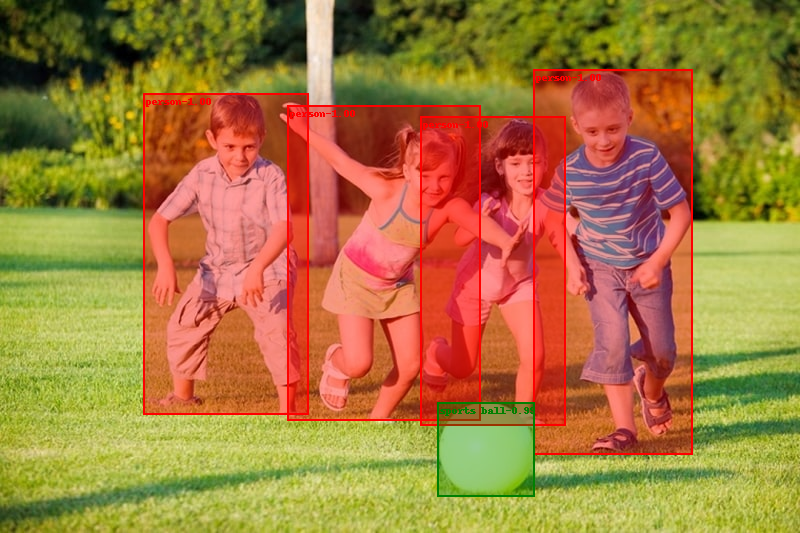

In [23]:
from torchvision.utils import draw_bounding_boxes

kids_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(kids_labels, kids_preds[0]["scores"].detach().numpy())]

kids_output = draw_bounding_boxes(image=kids_playing_tensor_int[0],
                             boxes=kids_preds[0]["boxes"],
                             labels=kids_annot_labels,
                             colors=["red" if label["name"]=="person" else "green" for label in kids_labels],
                             width=2,
                             font_size=16,
                             fill=True
                            )

to_pil_image(kids_output)

## 5. Try Other Pre-Trained Models

PyTorch torchvision module provides an implementation of other models as well which we have imported below. We'll suggest readers to try them if the above model is not giving that much good results.



In [24]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn,\
                                         fasterrcnn_mobilenet_v3_large_fpn,\
                                         fcos_resnet50_fpn,\
                                         ssdlite320_mobilenet_v3_large,\
                                         ssd300_vgg16,\
                                         retinanet_resnet50_fpn

## End of notebook!

In [ ]:
# EXTRA MATERIAL (if you are interested)

#TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
#Colab version:
#https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb